# Beautif.ai classification

The goal of your project is to create a robust classifier, to collect data and prepare custom dataset.  
You will build a model that will recognize 4 types of natural events in nature/indoor/outdoor:

* Daylight sky 
  * <img src = "https://ak.picdn.net/shutterstock/videos/7077064/thumb/1.jpg" width = "50%" height="50%">
* Sky at night
  * <img src="https://i.pinimg.com/originals/ec/98/dd/ec98dd97904e60661b1d545a88006e6a.jpg" width="50%" height="50%"/>

* Picture doesn't contain sky (no matter it's day or night)
  * <img src= "https://www.hotelsolun.com/application/files/5515/6285/1004/1X9A8812.jpg" width="50%" height="50%"/>


This project consists of the following activities :


1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about neural networks
    * Compose neural network architectures
    * Ping Pong phase with Dataset labelers
    * Generate syntethic data if needed
    * Fine tunning of your model
3. Phase 3 : Deployment
    * Analysis and benchmark Precision/Recall
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


# Load Data

In [ ]:
import os, sys, shutil, random, cv2
from google.colab import drive
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.datasets import load_files
from sklearn.metrics import classification_report

import keras
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
#from keras.applications.xception import preprocess_input as X_pre
#from keras.applications.resnet50 import preprocess_input as Res_pre
from keras.applications.densenet import preprocess_input 

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet201
from keras.applications.densenet import DenseNet169
from keras.applications.resnet import ResNet50

from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint

plt.style.use( "ggplot" )

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def split_test_valid( split_ratio, set_path, random_seed = 1, print_ratio = False, include_path = True ) :

    """
    This functions lists through a directory containing different sets in sorted subdirectories and returns test_x, valid_x, test_labels, valid_labels ( or x and y ) for further use.
    The arguments that need to be provided:
        split_ratio: is the ratio for the data set to be split along. Acceptable input is a float between 0 and 1 i.e. the percentage needed for further use; 
        set_path: is the path to the main directory where the subdirectories are located.
    Optional arguments:
         random_seed: is self-explanatory;
         print_ratio: prints the int ratio of the split.
         include_path: whether or not to include the full path in the train and test sets.
            If True returns: '/content/drive/MyDrive/Directory/Subdirectiory/Image.jpg';
            If False returns: 'Image.jpg'.
    """

    random.seed( random_seed )
    
    total = 0

    test_x = []
    valid_x = []
    test_labels = []
    valid_labels = []

    default_location = os.getcwd()

    if set_path[ -1 ] == "/" :
        set_path = set_path[0:-1]

    os.chdir( set_path )
    list_dir = os.listdir( set_path )

    for folder in list_dir :
        os.chdir( f'{ set_path}/{ folder }' )
        how_many =  len( os.listdir() )
        total += how_many

        test_set = int( round( how_many * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( how_many * split_ratio, 0 ) )

        nums = [ x for x in range( 1, how_many ) ]
        random_nums = random.sample( nums, valid_set )

        # The split itself :
        for ind, item in enumerate( os.listdir() ):

            if ind in random_nums :
                if include_path == True :
                    valid_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    valid_x.append( item )

                valid_labels.append( folder )

            if ind not in random_nums :

                if include_path == True :
                    test_x.append( f"{set_path}/{folder}/{item}" )
                elif include_path == False :
                    test_x.append( item )

                test_labels.append( folder )

        if print_ratio == True :

            print( f"Set: { folder } - { how_many } items" )
            print( f"Train: { test_set }" )
            print( f"Validation: { valid_set }" )
            print( f"Total: { test_set + valid_set }" )
            print( "---------" )
        elif print_ratio == False :
            pass

    os.chdir( default_location )
    
    if print_ratio == True :
        test_set = int( round( total * ( 1 - split_ratio ), 0 ) )
        valid_set = int( round( total * split_ratio, 0 ) )

        print( "---------" ) 
        print( f"United set: { total } items" )
        print( f"Train: { test_set }" )
        print( f"Validation: { valid_set }" )
        print( f"Total: { test_set + valid_set }" )
        print( "---------" )
    elif print_ratio == False :
            pass

    return test_x, valid_x, test_labels, valid_labels

In [ ]:
set_path = "/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224"
#set_path = "/content/drive/MyDrive/siensmiens/labeled"
split_ratio = 0.15

train_x, validation_x, train_labels, validation_labels  = split_test_valid( split_ratio, set_path, random_seed = 42, print_ratio = True )

Set: Night-Separated - 658 items
Train: 559
Validation: 99
Total: 658
---------
Set: No_Sky - 3791 items
Train: 3222
Validation: 569
Total: 3791
---------
Set: Day - 3304 items
Train: 2808
Validation: 496
Total: 3304
---------
Set: Night-Not_Separated - 887 items
Train: 754
Validation: 133
Total: 887
---------
---------
United set: 8640 items
Train: 7344
Validation: 1296
Total: 8640
---------


In [ ]:
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

le = preprocessing.LabelEncoder()

le.fit(train_labels)

train_targets = le.transform(train_labels)
val_targets = le.transform(validation_labels)

train_targets = np_utils.to_categorical(train_targets,num_classes=4)
val_targets = np_utils.to_categorical(val_targets,num_classes=4)

# Visualize Data Distribution

# Image Preprocessing

In [ ]:
def load_image( path ) :
  # READ AND PREPROCESS IMAGE HERE
  #cv2.imread
  image = cv2.imread( path ).astype( np.float32 )
  image_resized = preprocess_input( image )
  return image_resized

def load_dataset( files ) :

  print( "Preprocess initalized...\n" )

  process = 0
  len_dir = len( files )
  vector = []
  brojcanik = 0
  for file in files :

    vector.append( load_image( file ) )

    process += 1
    process_percentage = round( ( process / len_dir ) * 100, 0 )
    process_output = f"Processed: { process } / { len_dir } - { int( process_percentage ) }%"
    sys.stdout.write( '\r' + process_output )
    
  print( f"\n\n{ files } preprocess completed." )
  
  return np.array( vector )

In [ ]:
X_train = load_dataset( train_x )
X_val = load_dataset( validation_x )

Preprocess initalized...

Processed: 7343 / 7343 - 100%

['/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_290.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_54.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_144.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_200.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_381.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_304.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_96.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_159.jpg', '/content/drive/MyDrive/edited_Jasmina_labeled_resized_224x224/Night-Separated/night_separated_131.jpg',

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

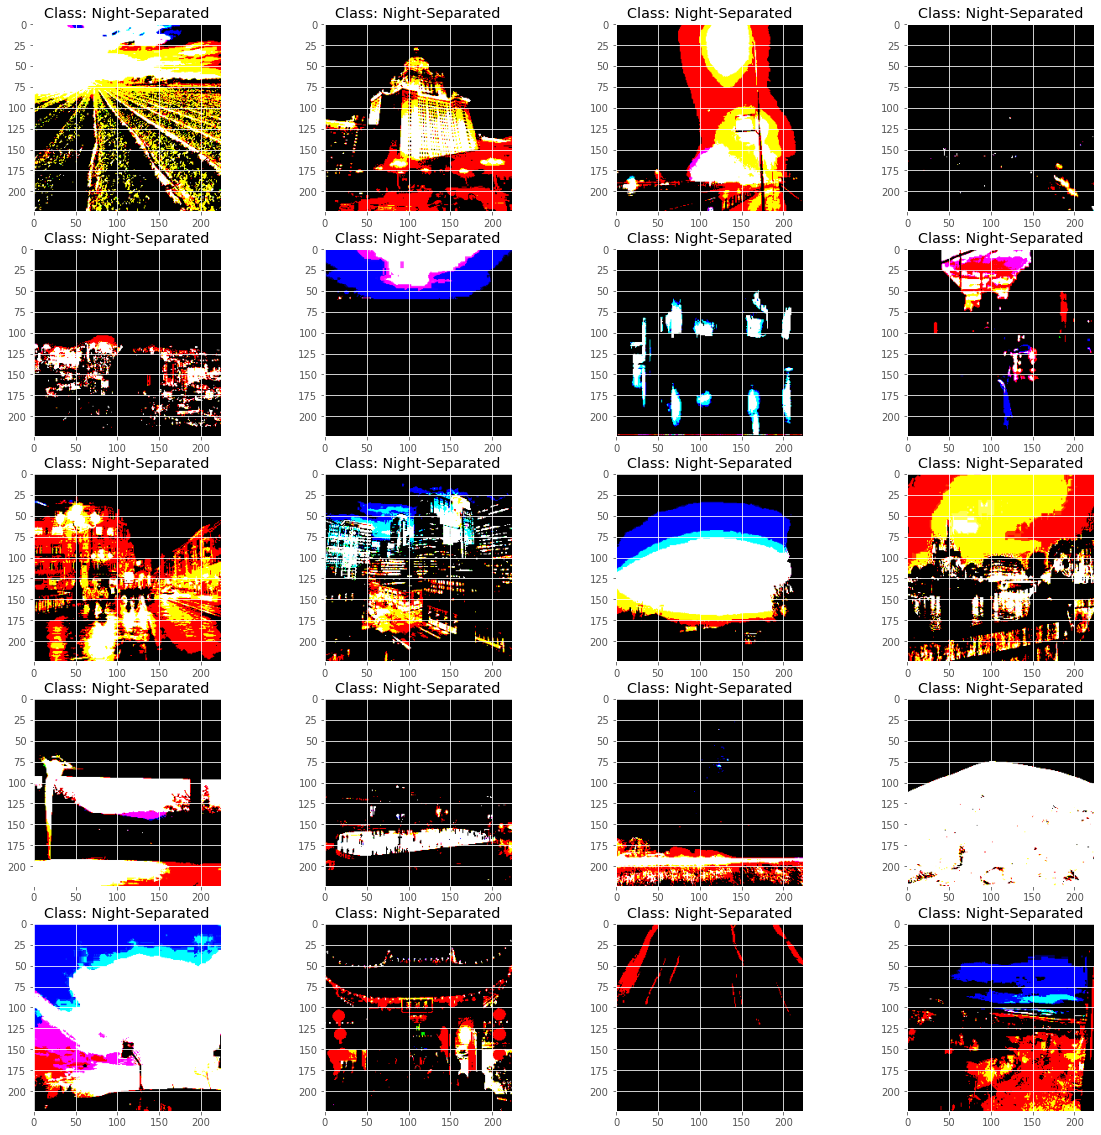

In [ ]:
fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_train[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + train_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

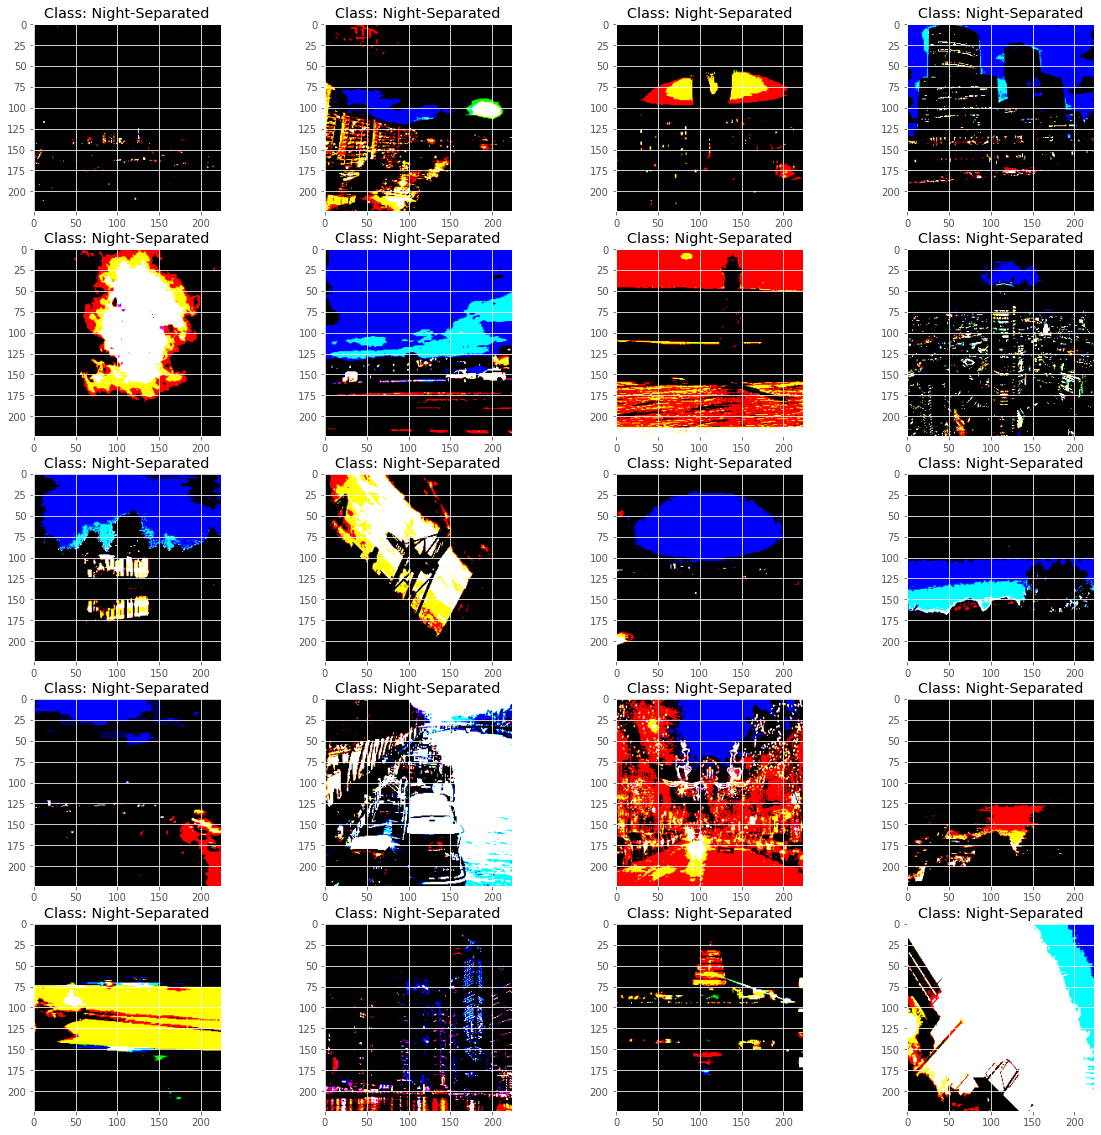

In [ ]:
fig = plt.figure(figsize=(20,20))

for i in range( 5 * 4 ) :
    # dodavanje na podgrafik
    ax1 = fig.add_subplot( 5, 4, ( i + 1 ) )
    # crtanje na podgrafikot
    ax1.imshow( X_val[ i ] )
    #  dodavanje na tekst na podgrafikot
    title = "Class: " + validation_labels[ i ]
    plt.title( title )

# snimanje na grafikot
plt.show()

# Define Model Architecture

In [ ]:
model = DenseNet201( include_top = False, input_shape = ( 224, 224, 3 ), weights = 'imagenet' )
for layer in model.layers :
  layer.trainable = False
flat = Flatten()( model.output )
hidden = Dense( 1024, activation = 'relu' )( flat )
batch_norm = BatchNormalization()(hidden)
dropout = Dropout(0.2)(batch_norm)
hidden1 = Dense(256, activation='relu')(dropout)
batch_norm1 = BatchNormalization()(hidden1)
dropout1 = Dropout(0.2)(batch_norm1)
outputs = Dense(4, activation='softmax')(dropout1)
model = Model(inputs = model.inputs, outputs = outputs)


74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
#  model = Sequential

# model = DenseNet201( include_top = False, input_shape = ( 224, 224, 3 ), weights = 'imagenet' )
# for layer in model.layers:
#   layer.trainable=False
# flat = Flatten()( model.output )
# hidden1 = Dense( 1024, activation = 'relu' )( flat )
# norm1 = BatchNormalization()(hidden1)
# drop1 = Dropout(0.2)(norm1)

# #hidden2 = Dense( 512, activation = 'relu' )( drop1 )
# #norm2 = BatchNormalization()(hidden2)
# #drop2 = Dropout(0.5)(norm2)

# #hidden3 = Dense( 256, activation = 'relu' )( drop2)
# #norm3 = BatchNormalization()(hidden3)
# #drop3 = Dropout(0.2)(norm3)

# #hidden3 = Dense( 256, activation = 'relu' )( norm1)
# #norm3 = BatchNormalization()(hidden3)
# #drop3 = Dropout(0.2)(norm3)

# outputs = Dense( 4, activation = 'softmax' )( drop1)
# model = Model( inputs = model.inputs, outputs = outputs )

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

# Define Loss Function, Optimizator

In [ ]:
optimzer = keras.optimizers.Adam( lr = 0.001 )

model.compile( loss = 'categorical_crossentropy', optimizer = optimzer, metrics = [ 'accuracy' ] )

Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=10,
		zoom_range=0.1,
		width_shift_range=0.1,
		height_shift_range=0.1)


datagen.fit(X_train)

# Train the model


In [ ]:
checkpoint = ModelCheckpoint(     
                                'best_model_dense201new.pt', monitor = 'val_accuracy',
                                verbose = 1, save_best_only = True, mode = 'max'
                               )
model.fit(
                    X_train,
                    train_targets,
                    validation_data = ( X_val, val_targets ),
                    epochs = 100,
                    callbacks = [ checkpoint ], 
                    batch_size = 20
                        )

Epoch 1/100
368/368 [==============================] - 59s 133ms/step - loss: 1.0584 - accuracy: 0.6790 - val_loss: 0.6390 - val_accuracy: 0.7841

Epoch 00001: val_accuracy improved from -inf to 0.78412, saving model to best_model_dense201new.pt
INFO:tensorflow:Assets written to: best_model_dense201new.pt/assets
Epoch 2/100
368/368 [==============================] - 46s 125ms/step - loss: 0.4818 - accuracy: 0.8200 - val_loss: 0.5901 - val_accuracy: 0.7949

Epoch 00002: val_accuracy improved from 0.78412 to 0.79491, saving model to best_model_dense201new.pt
INFO:tensorflow:Assets written to: best_model_dense201new.pt/assets
Epoch 3/100
368/368 [==============================] - 46s 124ms/step - loss: 0.3745 - accuracy: 0.8640 - val_loss: 0.5680 - val_accuracy: 0.8072

Epoch 00003: val_accuracy improved from 0.79491 to 0.80725, saving model to best_model_dense201new.pt
INFO:tensorflow:Assets written to: best_model_dense201new.pt/assets
Epoch 4/100
368/368 [==============================]

KeyboardInterrupt: ignored

In [ ]:
Y_pred = model.predict( X_val )

In [ ]:
real_prediction = np.argmax(Y_pred, axis=1)
real_targets = np.argmax(val_targets, axis=1)

In [ ]:
#Y_pred = model.predict( X_val )

target_names = [ 'Day', 'Night-Not_Separated', 'Night-Separated', 'No_Sky' ]

#print( classification_report( val_targets, Y_pred.round(), target_names = target_names ) )
print(classification_report(real_targets, real_prediction, target_names=target_names))

                     precision    recall  f1-score   support

                Day       0.87      0.82      0.84       496
Night-Not_Separated       0.70      0.58      0.63       133
    Night-Separated       0.74      0.53      0.62        99
             No_Sky       0.78      0.90      0.84       569

           accuracy                           0.81      1297
          macro avg       0.78      0.71      0.73      1297
       weighted avg       0.81      0.81      0.80      1297



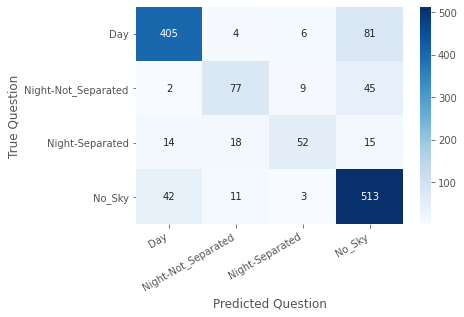

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_names=['Day', 'Night-Not_Separated', 'Night-Separated', 'No_Sky']
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Question')
  plt.xlabel('Predicted Question');

cm = confusion_matrix(real_targets, real_prediction)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
def get_prediction(image):
    image = np.expand_dims(image, axis=0)
    
    # istreniraniot model go koristime za prepoznavanje
    prediction = model.predict(image)
    # prepoznaenata klasa ni e indeksot od najgolemata vrednost vo izlezot (prediction), najgolemata verojatnost
    predicted_class = np.argmax(prediction)
    return target_names[predicted_class]

In [ ]:
import urllib.request
import cv2

def url_to_image(url):
  resp = urllib.request.urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # PREPROCESS YOUR INPUT
  image_preprocessed = preprocess_input(cv2.resize(image, dsize = (224,224)))
  return image_preprocessed, image_

def predict_url(url):
  image_resized, image = url_to_image(url)
  predicted_class = get_prediction(image_resized)
  plt.imshow(image)
  plt.title("Предвидено : " + predicted_class)

##Predict Here:

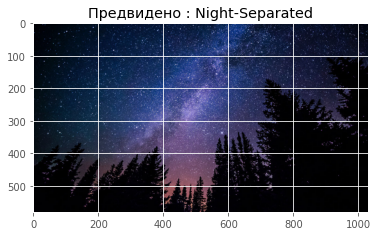

In [ ]:
predict_url("https://www.sciencenews.org/wp-content/uploads/2019/09/091119_mt_antisolar_feat.jpg")

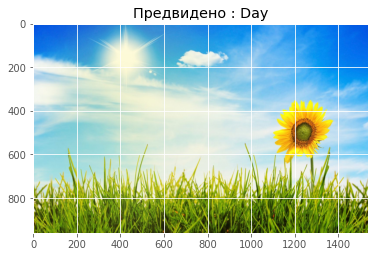

In [ ]:
predict_url("https://scontent.fskp2-1.fna.fbcdn.net/v/t31.0-8/p960x960/10945111_1532150797037312_5930509058927773875_o.jpg?_nc_cat=111&ccb=3&_nc_sid=e3f864&_nc_ohc=FfcA0O6r2LAAX_L3gIe&_nc_ht=scontent.fskp2-1.fna&tp=6&oh=6b433ef1607a363f79d6bff5242a6112&oe=604F3D3A")

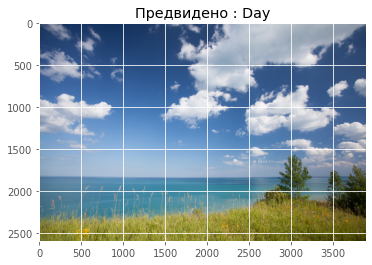

In [ ]:
predict_url("https://picjumbo.com/wp-content/uploads/view-of-the-lake-michigan-on-a-sunny-day.jpg")

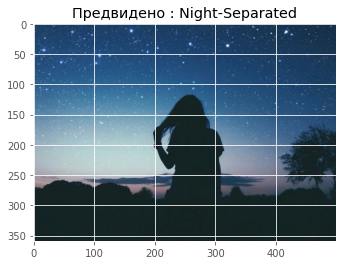

In [ ]:
predict_url("https://i.pinimg.com/564x/bf/53/06/bf53068baf3947f713084cb9cd2e42fa.jpg")
#wrongly predicted in dense169

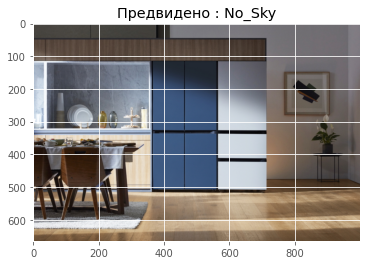

In [ ]:
predict_url("https://img.global.news.samsung.com/global/wp-content/uploads/2020/01/Innovative-Lifestyle_main1FFF.jpg")

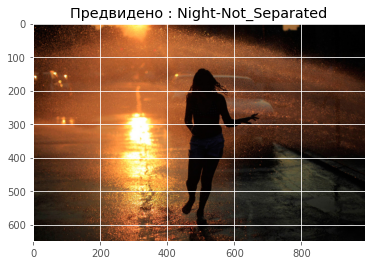

In [ ]:
predict_url("http://inapcache.boston.com/universal/site_graphics/blogs/bigpicture/summertime10_07_07/s01_24229807.jpg")

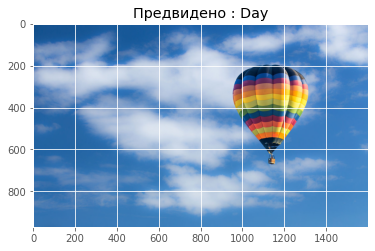

In [ ]:
predict_url("https://cdn.britannica.com/74/182174-050-6755AB49/balloon-sky.jpg")

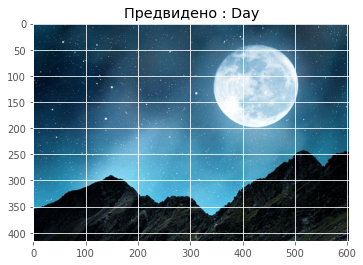

In [ ]:
predict_url("https://www.thebmc.co.uk/Handlers/ArticleImageHandler.ashx?id=7467&index=0&w=605&h=434")
#wrongly predicted - day in dense169
#wrongly predicted - day in dense201 (with batch normalization, 001))

# Example :  
   Provide several examples of predictions along with softmax score probability

# Benchmark

# Summary about your results